# Preliminaries

In [35]:
# import modules
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [36]:
# base classes

class Node:
    pass


class Tree:
    def __init__(self):
        self.root = Node()

    def find_leaf(self, x) -> Node:
        node = self.root
        while hasattr(node, "feature"):
            j = node.feature
            if x[j] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node

# Density Tree

In [37]:
def calc_bbox(data) -> (np.ndarray, np.ndarray):
    return np.min(data, axis=0).copy(), np.max(data, axis=0).copy()


class DensityTree(Tree):
    def __init__(self):
        super(DensityTree, self).__init__()

    def train(self, data, prior, n_min=20):
        '''
        data: the feature matrix for the digit under consideration
        prior: the prior probability of this digit
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        self.prior = prior
        N, D = data.shape
        D_try = int(np.sqrt(D))  # number of features to consider for each split decision

        # find and remember the tree's bounding box, 
        # i.e. the lower and upper limits of the training feature set
        m, M = calc_bbox(data)
        self.box = m, M

        # identify invalid features and adjust the bounding box
        # (If m[j] == M[j] for some j, the bounding box has zero volume, 
        #  causing divide-by-zero errors later on. We must exclude these
        #  features from splitting and adjust the bounding box limits 
        #  such that invalid features have no effect on the volume.)
        valid_features = np.where(m != M)[0]
        invalid_features = np.where(m == M)[0]
        M[invalid_features] = m[invalid_features] + 1

        # initialize the root node
        self.root.data = data
        self.root.box = m.copy(), M.copy()

        # build the tree
        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0]  # number of instances in present node
            if n >= n_min:
                # Call 'make_density_split_node()' with 'D_try' randomly selected 
                # indices from 'valid_features'. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                indices = np.random.choice(np.arange(0, len(valid_features)), D_try, False)
                left, right = make_density_split_node(node, N, valid_features[indices])
                stack.append(left)
                stack.append(right)
            else:
                # Call 'make_density_leaf_node()' to turn 'node' into a leaf node.
                make_density_leaf_node(node, N)

    def predict(self, x):
        leaf = self.find_leaf(x)
        # return p(x | y) * p(y) if x is within the tree's bounding box 
        # and return 0 otherwise

        if np.sum(x < self.box[0]) > 0 or np.sum(x > self.box[1]) > 0:
            return 0.0
        return self.prior * leaf.response

In [38]:
def calc_loo_error(N_m: int, N: int, V_m: float) -> float:
    # print()
    # print(f'N_m = {N_m}')
    # print(f'N = {N}')
    # print(f'V_m = {V_m}')
    # print(f'-(2 * N_m * (N_m - 1)) = {-(2 * N_m * (N_m - 1))}')
    # print(f'(N * (N - 1) * V_m) = {(N * (N - 1) * V_m)}')
    # print(f'(N_m ** 2) = {(N_m ** 2)}')
    # print(f'((N ** 2) * V_m) = {((N ** 2) * V_m)}')
    # print(f'-(2 * N_m * (N_m - 1)) / (N * (N - 1) * V_m) = {-(2 * N_m * (N_m - 1)) / (N * (N - 1) * V_m)}')
    # print(f'(N_m ** 2) / ((N ** 2) * V_m) = {(N_m ** 2) / ((N ** 2) * V_m)}')
    # print()
    return -(2 * N_m * (N_m - 1)) / (N * (N - 1) * V_m) + (N_m ** 2) / ((N ** 2) * V_m)


def calc_volume(bounding_box: Tuple[np.ndarray, np.ndarray]):
    m, M = bounding_box
    return np.prod(M - m)


def make_density_split_node(node, N, feature_indices):
    '''
    node: the node to be split
    N:    the total number of training instances for the current class
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape
    m, M = node.box

    # find best feature j (among 'feature_indices') and best threshold t for the split
    e_min = float("inf")
    j_min, t_min = 0, 0

    volume = calc_volume((m, M))

    for j in feature_indices:
        # Hint: For each feature considered, first remove duplicate feature values using
        # 'np.unique()'. Describe here why this is necessary.

        # It's necessary because otherwise if two instances have the same feature value the mean between them is the feature value self so the threshold would not be in the mid between feature values anymore

        # np.unique returns an already sorted array
        data_unique = np.unique(node.data[:, j])
        # Compute candidate thresholds
        tj = 0.5 * (data_unique[1:] + data_unique[:-1])

        # Illustration: for loop - hint: vectorized version is possible
        for t in tj:
            # Compute the error
            N_l = np.sum(node.data[:, j] <= t)
            N_r = n - N_l

            l_volume = volume * t / (M[j] - m[j])
            r_volume = volume - l_volume

            if l_volume != 0 and r_volume != 0:
                loo_err_l = calc_loo_error(N_l, N, l_volume)
                loo_err_r = calc_loo_error(N_r, N, r_volume)

                loo_error = loo_err_l + loo_err_r

                # print(f'loo_error: {loo_error}')

                # choose the best threshold that
                if loo_error < e_min:
                    # print(f'e_min: {e_min}, j_min: {j_min}, t_min: {t_min}')
                    e_min = loo_error
                    j_min = j
                    t_min = t

    # create children
    left = Node()
    right = Node()

    # initialize 'left' and 'right' with the data subsets and bounding boxes
    # according to the optimal split found above
    left.data = node.data[node.data[:, j_min] <= t_min, :]  # store data in left node -- for subsequent splits
    left.box = m.copy(), M.copy()  # store bounding box in left node
    left.box[1][j_min] = t_min
    right.data = node.data[node.data[:, j_min] > t_min, :]
    right.box = m.copy(), M.copy()
    right.box[0][j_min] = t_min

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right

In [39]:
def make_density_leaf_node(node, N):
    '''
    node: the node to become a leaf
    N:    the total number of training instances for the current class
    '''
    # compute and store leaf response
    n = node.data.shape[0]
    v = calc_volume(node.box)
    node.response = n / (N * v)

# Decision Tree

In [40]:
class DecisionTree(Tree):
    def __init__(self):
        super(DecisionTree, self).__init__()

    def train(self, data, labels, n_min=20):
        '''
        data: the feature matrix for all digits
        labels: the corresponding ground-truth responses
        n_min: termination criterion (don't split if a node contains fewer instances)
        '''
        N, D = data.shape
        D_try = int(np.sqrt(D))  # how many features to consider for each split decision

        # initialize the root node
        self.root.data = data
        self.root.labels = labels

        stack = [self.root]
        while len(stack):
            node = stack.pop()
            n = node.data.shape[0]  # number of instances in present node
            if n >= n_min and not node_is_pure(node):
                # Call 'make_decision_split_node()' with 'D_try' randomly selected 
                # feature indices. This turns 'node' into a split node
                # and returns the two children, which must be placed on the 'stack'.
                indices = np.random.choice(np.arange(0, D), D_try, False)
                left, right = make_decision_split_node(node, indices)
                stack.append(left)
                stack.append(right)
            else:
                # Call 'make_decision_leaf_node()' to turn 'node' into a leaf node.
                make_decision_leaf_node(node)

    def predict(self, x):
        leaf = self.find_leaf(x)
        # compute p(y | x)
        return np.argmax(leaf.response)

In [41]:
def calc_gini(N_l_k: np.ndarray, N_l: int) -> float:
    return N_l * (1 - np.sum((N_l_k / N_l) ** 2))


def calc_N_l_k(node_target: np.ndarray, tresholded_indices: np.ndarray) -> np.ndarray:
    return np.bincount(node_target[tresholded_indices], minlength=10)


def make_decision_split_node(node, feature_indices):
    '''
    node: the node to be split
    feature_indices: a numpy array of length 'D_try', containing the feature 
                     indices to be considered in the present split
    '''
    n, D = node.data.shape

    e_min = float('inf')
    t_min, j_min = 0, 0

    # find best feature j (among 'feature_indices') and best threshold t for the split
    for j in feature_indices:
        data_unique = np.unique(node.data[:, j])
        tj = 0.5 * (data_unique[1:] + data_unique[:-1])

        if len(data_unique) > 1:
            for t in tj:
                indices_l = np.where(node.data[:, j] <= t)
                indices_r = np.where(node.data[:, j] > t)

                N_l_k_l = calc_N_l_k(node.labels, indices_l)
                N_l_k_r = calc_N_l_k(node.labels, indices_r)

                N_l_l = len(indices_l)
                N_l_r = len(indices_r)

                gini_l = calc_gini(N_l_k_l, N_l_l)
                gini_r = calc_gini(N_l_k_r, N_l_r)

                gini = gini_l + gini_r

                if gini < e_min:
                    e_min = gini
                    t_min = t
                    j_min = j

    # create children
    left = Node()
    right = Node()

    # initialize 'left' and 'right' with the data subsets and labels
    # according to the optimal split found above
    indices_l = np.where(node.data[:, j_min] <= t_min)
    indices_r = np.where(node.data[:, j_min] > t_min)

    left.data = node.data[indices_l]  # data in left node
    left.labels = node.labels[indices_l]  # corresponding labels
    right.data = node.data[indices_r]
    right.labels = node.labels[indices_r]

    # if len(left.data) == 0 or len(right.data) == 0:
    #     print('Data empty')

    # turn the current 'node' into a split node
    # (store children and split condition)
    node.left = left
    node.right = right
    node.feature = j_min
    node.threshold = t_min

    # return the children (to be placed on the stack)
    return left, right

In [42]:
def make_decision_leaf_node(node):
    '''
    node: the node to become a leaf
    '''
    # compute and store leaf response
    node.N = len(node.labels)
    node.response = np.bincount(node.labels, minlength=10) / node.N

In [43]:
def node_is_pure(node):
    '''
    check if 'node' ontains only instances of the same digit
    '''
    return len(np.unique(node.labels)) <= 1

# Evaluation of Density and Decision Tree
Below we first load the dataset and reduce the dimensions to the dimensions with actual information in it (deleting the features with variance 0, because if every datapoint has the same value in one feature, the feature does not carry any information)


In [44]:
# read and prepare the digits data
from sklearn.datasets import load_digits

digits = load_digits()

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

# Removing features where min value == max value == 0, because this feature does not contain any information (it's the same for all instances)
smallest, biggest = calc_bbox(data)
distances = biggest - smallest
print(distances.shape)

dims_with_information = np.where(distances > 0)[0]
print(dims_with_information)

data = data[:, dims_with_information]
print(data.shape)

(64,)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 33 34 35 36 37 38 40 41 42 43 44 45 46 47 48 49 50
 51 52 53 54 55 56 57 58 59 60 61 62 63]
(1797, 61)


Afterwards we define a function to calculate the confusion matrix from  $\hat{y}$ and $y*$ by comparing the expected y's per class with the calculated y's then bin counting that for each column in the confusion matrix.

In [45]:
# train trees, plot training error confusion matrices, and comment on your results

def calc_confusion_matrix(calculated_target, expected) -> pd.DataFrame:
    matrix = np.zeros((10, 10))
    matrix_dict = {}
    for expected_num in range(10):
        expected_indices = np.where(expected == expected_num)[0]
        calculated_values = calculated_target[expected_indices]
        calc_bins = np.bincount(calculated_values, minlength=10)
        matrix[expected_num] = calc_bins / len(expected_indices)
        matrix_dict[expected_num] = calc_bins / len(expected_indices)

    data_frame = pd.DataFrame(matrix_dict)
    data_frame.columns.name = 'actual/expected'
    return data_frame


Then we define a function that plots us the error per n_min for the different classifiers.

In [46]:
def show_plot(errors: np.ndarray, n_mins: np.ndarray):
    x = range(len(n_mins))
    x_ticks = np.arange(len(n_mins))
    fig, ax = plt.subplots()
    ax.bar(x, errors)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(n_mins)
    plt.show()


Then we create a one function for training and testing the generative classifier and one for the discriminative classifier.
For training and testing the generative classifier, we first train each of the classifiers independently for exactly one class. Therefore we filter our test data for this class and then pass the filtered data and the calculated prior to the train function of the classifier.
Afterwards we test by calculating the probability for each data point per classifier the classifier with the highest probability wins and determines which class the datapoint belongs to. With the results we then calculate the error and the confusion matrix.

For the discriminative classifier we only have one instance which returns the class with the highest probability. We train the classifier with the data, predict afterwards each class per datapoint and then generate the confusion matrix and error rate out of it.

In [47]:
def train_test_generative_classifier(generative_classifiers, n_min) -> float:
    assert len(generative_classifiers) == 10
    for number, density_tree in enumerate(generative_classifiers):
        indices = np.where(target == number)
        filtered_data = data[indices]
        prior = len(filtered_data) / len(data)

        density_tree.train(filtered_data, prior, n_min)

    calculated_target = np.zeros(len(target), dtype=int)

    for i, instance in enumerate(data):
        p_max = -1
        num_max = -1
        for number, tree in enumerate(generative_classifiers):
            p = tree.predict(instance)
            if p > p_max:
                p_max = p
                num_max = number
        calculated_target[i] = num_max

    # print(target)
    # print(calculated_target)
    density_tree_err = calculated_target != target
    # print(density_tree_err)

    density_tree_err_rate = np.sum(density_tree_err) / len(target)
    confusion_matrix = calc_confusion_matrix(calculated_target, target)
    print(f'Error rate: {density_tree_err_rate}')
    print('Confusion matrix:')
    display(confusion_matrix)

    return density_tree_err_rate


def train_test_discriminative_classifier(discriminative_classifier, n_min) -> float:
    discriminative_classifier.train(data, target, n_min)

    calculated_target = np.array([discriminative_classifier.predict(instance) for instance in data], dtype=int)

    decision_tree_err = calculated_target != target
    # print(decision_tree_err)

    decision_tree_err_rate = np.sum(decision_tree_err) / len(target)
    confusion_matrix = calc_confusion_matrix(calculated_target, target)
    print(f'Error rate: {decision_tree_err_rate}')
    print('Confusion matrix:')
    display(confusion_matrix)

    return decision_tree_err_rate


The actual execution of the train and test methods from above is done in the train_test methods which accepts as first two parameters factory methods for creating new generative and discriminative classifiers. This is used for reusing the function for the forests.
The two second parameters are arrays of n_min values for the two different classifier types which shall be trained and tested.
The function itself just iterates ovet the n_mins for both the generative and discriminative classifiers and execute their respective train and test function from above.

Generative classifier:
n_min: 20
Error rate: 0.2036727879799666
Confusion matrix:


actual/expected,0,1,2,3,4,5,6,7,8,9
0,0.983146,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.000000,0.785714,0.112994,0.032787,0.016575,0.027473,0.01105,0.000000,0.120690,0.022222
2,0.000000,0.076923,0.677966,0.038251,0.000000,0.005495,0.00000,0.000000,0.011494,0.011111
3,0.000000,0.000000,0.022599,0.633880,0.000000,0.104396,0.00000,0.005587,0.005747,0.200000
4,0.016854,0.049451,0.000000,0.000000,0.850829,0.000000,0.00000,0.011173,0.005747,0.033333
5,0.000000,0.000000,0.022599,0.016393,0.011050,0.708791,0.00000,0.000000,0.011494,0.016667
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.98895,0.000000,0.000000,0.000000
7,0.000000,0.005495,0.000000,0.016393,0.116022,0.065934,0.00000,0.977654,0.011494,0.066667
8,0.000000,0.082418,0.163842,0.256831,0.005525,0.082418,0.00000,0.005587,0.833333,0.122222
9,0.000000,0.000000,0.000000,0.005464,0.000000,0.005495,0.00000,0.000000,0.000000,0.527778


n_min: 10
Error rate: 0.19810795770728992
Confusion matrix:


actual/expected,0,1,2,3,4,5,6,7,8,9
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.0,0.725275,0.016949,0.000000,0.011050,0.000000,0.005525,0.000000,0.034483,0.011111
2,0.0,0.043956,0.570621,0.027322,0.000000,0.000000,0.000000,0.000000,0.017241,0.011111
3,0.0,0.000000,0.050847,0.546448,0.000000,0.021978,0.000000,0.000000,0.000000,0.094444
4,0.0,0.032967,0.000000,0.000000,0.834254,0.005495,0.000000,0.005587,0.000000,0.027778
5,0.0,0.005495,0.000000,0.038251,0.016575,0.802198,0.000000,0.005587,0.000000,0.033333
6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.994475,0.000000,0.000000,0.000000
7,0.0,0.027473,0.000000,0.016393,0.110497,0.032967,0.000000,0.977654,0.022989,0.055556
8,0.0,0.131868,0.350282,0.158470,0.005525,0.098901,0.000000,0.000000,0.890805,0.083333
9,0.0,0.032967,0.011299,0.213115,0.022099,0.038462,0.000000,0.011173,0.034483,0.683333


n_min: 5
Error rate: 0.15859766277128548
Confusion matrix:


actual/expected,0,1,2,3,4,5,6,7,8,9
0,0.994382,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.769231,0.039548,0.005464,0.011050,0.005495,0.000000,0.000000,0.040230,0.016667
2,0.000000,0.093407,0.847458,0.114754,0.000000,0.005495,0.005525,0.000000,0.097701,0.016667
3,0.000000,0.000000,0.016949,0.732240,0.000000,0.093407,0.000000,0.000000,0.011494,0.233333
4,0.005618,0.021978,0.000000,0.000000,0.939227,0.005495,0.000000,0.011173,0.005747,0.033333
5,0.000000,0.010989,0.000000,0.000000,0.000000,0.813187,0.005525,0.000000,0.011494,0.005556
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.988950,0.000000,0.000000,0.000000
7,0.000000,0.027473,0.000000,0.010929,0.044199,0.027473,0.000000,0.983240,0.040230,0.044444
8,0.000000,0.076923,0.096045,0.109290,0.005525,0.043956,0.000000,0.000000,0.793103,0.094444
9,0.000000,0.000000,0.000000,0.027322,0.000000,0.005495,0.000000,0.005587,0.000000,0.555556


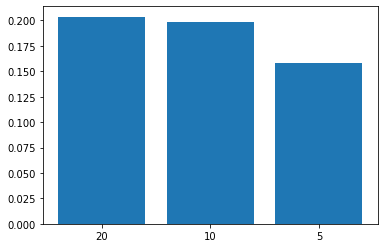


Discriminative classifier:
n_min: 20
Error rate: 0.31886477462437396
Confusion matrix:


actual/expected,0,1,2,3,4,5,6,7,8,9
0,0.814607,0.000000,0.016949,0.005464,0.016575,0.000000,0.005525,0.022346,0.028736,0.038889
1,0.005618,0.884615,0.050847,0.010929,0.060773,0.032967,0.022099,0.027933,0.109195,0.061111
2,0.011236,0.000000,0.598870,0.054645,0.005525,0.027473,0.011050,0.000000,0.097701,0.077778
3,0.005618,0.027473,0.090395,0.633880,0.005525,0.126374,0.016575,0.022346,0.103448,0.111111
4,0.011236,0.000000,0.011299,0.010929,0.762431,0.038462,0.005525,0.100559,0.000000,0.027778
5,0.005618,0.010989,0.135593,0.109290,0.011050,0.648352,0.011050,0.050279,0.086207,0.066667
6,0.022472,0.038462,0.045198,0.098361,0.022099,0.027473,0.906077,0.005587,0.091954,0.094444
7,0.056180,0.010989,0.000000,0.032787,0.088398,0.060440,0.000000,0.731844,0.017241,0.066667
8,0.028090,0.005495,0.033898,0.027322,0.016575,0.010989,0.005525,0.000000,0.425287,0.061111
9,0.039326,0.021978,0.016949,0.016393,0.011050,0.027473,0.016575,0.039106,0.040230,0.394444


n_min: 10
Error rate: 0.19365609348914858
Confusion matrix:


actual/expected,0,1,2,3,4,5,6,7,8,9
0,0.966292,0.000000,0.000000,0.005464,0.016575,0.005495,0.000000,0.011173,0.017241,0.022222
1,0.000000,0.917582,0.056497,0.027322,0.005525,0.038462,0.011050,0.072626,0.097701,0.038889
2,0.000000,0.027473,0.768362,0.071038,0.016575,0.016484,0.000000,0.011173,0.097701,0.061111
3,0.005618,0.005495,0.056497,0.721311,0.005525,0.005495,0.044199,0.027933,0.091954,0.088889
4,0.016854,0.010989,0.016949,0.010929,0.895028,0.016484,0.000000,0.055866,0.017241,0.011111
5,0.000000,0.000000,0.045198,0.016393,0.016575,0.884615,0.000000,0.016760,0.022989,0.005556
6,0.005618,0.000000,0.011299,0.016393,0.000000,0.000000,0.944751,0.000000,0.000000,0.005556
7,0.000000,0.016484,0.000000,0.010929,0.027624,0.021978,0.000000,0.782123,0.028736,0.055556
8,0.005618,0.010989,0.016949,0.032787,0.005525,0.005495,0.000000,0.005587,0.534483,0.072222
9,0.000000,0.010989,0.028249,0.087432,0.011050,0.005495,0.000000,0.016760,0.091954,0.638889


n_min: 5
Error rate: 0.10962715637173066
Confusion matrix:


actual/expected,0,1,2,3,4,5,6,7,8,9
0,0.971910,0.000000,0.000000,0.005464,0.000000,0.000000,0.000000,0.000000,0.000000,0.016667
1,0.000000,0.939560,0.039548,0.010929,0.011050,0.016484,0.000000,0.022346,0.051724,0.005556
2,0.000000,0.000000,0.892655,0.065574,0.027624,0.043956,0.033149,0.000000,0.068966,0.011111
3,0.005618,0.010989,0.028249,0.846995,0.005525,0.043956,0.011050,0.005587,0.074713,0.038889
4,0.011236,0.000000,0.000000,0.005464,0.950276,0.016484,0.005525,0.039106,0.011494,0.005556
5,0.005618,0.000000,0.005650,0.010929,0.000000,0.873626,0.016575,0.022346,0.017241,0.027778
6,0.005618,0.010989,0.000000,0.021858,0.005525,0.005495,0.922652,0.000000,0.011494,0.011111
7,0.000000,0.000000,0.000000,0.016393,0.000000,0.000000,0.000000,0.893855,0.000000,0.011111
8,0.000000,0.032967,0.033898,0.005464,0.000000,0.000000,0.011050,0.005587,0.752874,0.016667
9,0.000000,0.005495,0.000000,0.010929,0.000000,0.000000,0.000000,0.011173,0.011494,0.855556


n_min: 0
Error rate: 0.0
Confusion matrix:


actual/expected,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


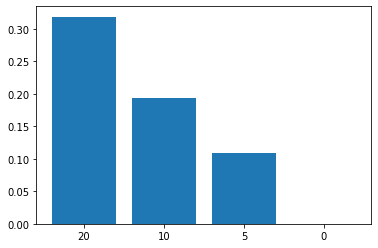

In [48]:
def train_test(create_generative_classifiers, create_discriminative_classifier, generative_n_mins,
               discriminative_n_mins):
    density_tree_error = []
    print('Generative classifier:')
    for hyper_n_min in generative_n_mins:
        print(f'n_min: {hyper_n_min}')
        density_trees = create_generative_classifiers()
        error = train_test_generative_classifier(density_trees, hyper_n_min)
        density_tree_error.append(error)
    show_plot(density_tree_error, generative_n_mins)

    decision_tree_error = []
    print()
    print('Discriminative classifier:')
    for hyper_n_min in discriminative_n_mins:
        print(f'n_min: {hyper_n_min}')
        error = train_test_discriminative_classifier(create_discriminative_classifier(), hyper_n_min)
        decision_tree_error.append(error)
    show_plot(decision_tree_error, discriminative_n_mins)


train_test(lambda: [DensityTree() for _ in range(10)], lambda: DecisionTree(), [20, 10, 5], [20, 10, 5, 0])

#train_test(lambda: [], lambda: DecisionTree(), [], [0])


As a result the discriminative classifier (decision tree) performs a lot better than the density tree. For decreasing n_mins the error rate also decreases for both classifiers.
With n_min = 0 for the decision tree performs a perfect fit on the train data, this means every node is pure and therefore every datapoint from the training set will be categorized correctly. Unfortunately this might also be overfitting and test data might perform in another way.

The confusion matrix can be read as following: The diagonal is the share of correctly classified numbers ranging from zero to one. The other values in the matrix are the respective share of  the wrongly categorized values. e.g. for the generative classifier with n_min = 20 the share of wrongly classified 2 when expecting a 1 is 0.076923.

# Density and Decision Forest

In [49]:
class DensityForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DensityTree() for i in range(n_trees)]

    def train(self, data, prior, n_min=20):
        for tree in self.trees:
            # train each tree, using a bootstrap sample of the data

            train_indices = np.random.choice(np.arange(len(data)), len(data), True)
            train_data = data[train_indices]
            tree.train(train_data, prior, n_min)

    def predict(self, x):
        # compute the ensemble prediction
        return np.sum(np.array([tree.predict(x) for tree in self.trees])) / len(self.trees)

In [50]:
class DecisionForest():
    def __init__(self, n_trees):
        # create ensemble
        self.trees = [DecisionTree() for i in range(n_trees)]

    def train(self, data, labels, n_min=0):
        for i, tree in enumerate(self.trees):
            # train each tree, using a bootstrap sample of the da
            # print(f'Training decision tree {i}')
            train_indices = np.random.choice(range(len(data)), len(data), True)
            train_data = data[train_indices]
            train_labels = labels[train_indices]
            tree.train(train_data, train_labels, n_min)
            # print(f'Decision tree {i} trained')

    def predict(self, x):
        # compute the ensemble prediction
        return np.argmax(np.bincount([tree.predict(x) for tree in self.trees], minlength=10))

# Evaluation of Density and Decision Forest
For the forest algorithms we reuse the evaluation functions from above and just pass a function that generates an array with 10 `DensityForest`s and a function which creates a new `DecisionForest`, As hyperparameters we choose n_min = 20 for the generative classifier (density forest) and n_min = 0 for the decision forest.

Generative classifier:
n_min: 20
Error rate: 0.10072342793544797
Confusion matrix:


actual/expected,0,1,2,3,4,5,6,7,8,9
0,0.994382,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.005618,0.945055,0.056497,0.005464,0.011050,0.000000,0.0,0.000000,0.074713,0.016667
2,0.000000,0.016484,0.853107,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.033898,0.836066,0.000000,0.049451,0.0,0.000000,0.005747,0.211111
4,0.000000,0.005495,0.000000,0.000000,0.961326,0.005495,0.0,0.000000,0.000000,0.011111
5,0.000000,0.005495,0.000000,0.010929,0.000000,0.879121,0.0,0.000000,0.005747,0.011111
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
7,0.000000,0.005495,0.000000,0.021858,0.027624,0.010989,0.0,0.994413,0.000000,0.044444
8,0.000000,0.021978,0.056497,0.120219,0.000000,0.043956,0.0,0.005587,0.913793,0.088889
9,0.000000,0.000000,0.000000,0.005464,0.000000,0.010989,0.0,0.000000,0.000000,0.616667


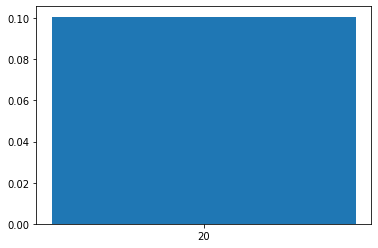


Discriminative classifier:
n_min: 20
Error rate: 0.12799109627156371
Confusion matrix:


actual/expected,0,1,2,3,4,5,6,7,8,9
0,0.977528,0.000000,0.000000,0.005464,0.022099,0.005495,0.000000,0.005587,0.005747,0.022222
1,0.000000,0.967033,0.039548,0.005464,0.011050,0.010989,0.016575,0.005587,0.022989,0.022222
2,0.000000,0.005495,0.875706,0.076503,0.000000,0.021978,0.000000,0.005587,0.063218,0.044444
3,0.005618,0.000000,0.039548,0.786885,0.000000,0.038462,0.011050,0.000000,0.040230,0.072222
4,0.005618,0.000000,0.005650,0.005464,0.922652,0.021978,0.005525,0.055866,0.011494,0.027778
5,0.000000,0.021978,0.011299,0.027322,0.016575,0.873626,0.000000,0.033520,0.051724,0.038889
6,0.005618,0.000000,0.011299,0.032787,0.000000,0.010989,0.966851,0.000000,0.017241,0.038889
7,0.000000,0.000000,0.011299,0.032787,0.027624,0.005495,0.000000,0.888268,0.000000,0.038889
8,0.005618,0.000000,0.005650,0.016393,0.000000,0.005495,0.000000,0.000000,0.787356,0.022222
9,0.000000,0.005495,0.000000,0.010929,0.000000,0.005495,0.000000,0.005587,0.000000,0.672222


n_min: 0


/tmp/ipykernel_145619/981153019.py:7: RuntimeWarning: invalid value encountered in true_divide
  node.response = np.bincount(node.labels, minlength=10) / node.N


Error rate: 0.0005564830272676684
Confusion matrix:


actual/expected,0,1,2,3,4,5,6,7,8,9
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005556
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.994444


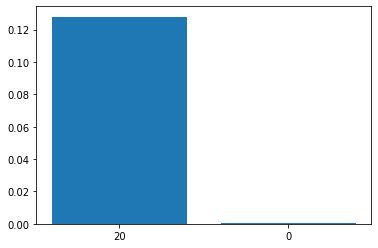

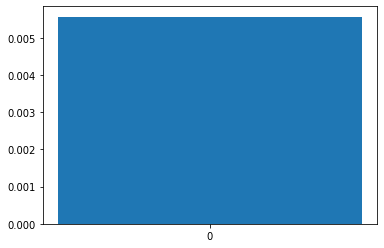

In [51]:
# train forests (with 20 trees per forest), plot training error confusion matrices, and comment on your results
train_test(lambda: [DensityForest(20) for _ in range(10)], lambda: DecisionForest(20), [20], [20, 0])

sklearn_random_forest = RandomForestClassifier(20, min_samples_split = 20)
sklearn_random_forest.fit(data,target)

sklean_calculated = sklearn_random_forest.predict(data)

sklearn_err = sklean_calculated != target
sklearn_err_rate = np.sum(sklearn_err) / len(target)
calc_confusion_matrix(sklean_calculated, target)
show_plot(np.array([sklearn_err_rate]), np.array([0]))


The difference in the results between the generative and the discriminative classifier continue for the forest algorithms. the Decision forest performs a lot better then the density forest. The density forest has an error rate in the parts-per-thousands range where the density forest has an error from around 10%.
The sklearn implementation of the random forest performs better for n_min= 20, but when setting n_min to 0 for the decision forest they perform quite similar
